In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('demand.csv')
df.head()
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index , format='%m/%d/%Y %H:%M')
df = df.rename(columns={ 'actual_performance(10000 kW)': 'demand'})

In [3]:
prefecture_files = {
    'osaka': 'osaka.csv',
    'hikone': 'hikone.csv',
    'kyoto': 'kyoto.csv',
    'kobe': 'kobe.csv',
    'shionomisaki': 'shionomisaki.csv',
    'toyooka': 'toyooka.csv',
    'wakayama': 'wakayama.csv'
}
weather_weights = {
    'osaka': 0.25,
    'hikone': 0.15,
    'kyoto': 0.2,
    'kobe': 0.15,
    'shionomisaki': 0.1,
    'toyooka': 0.1,
    'wakayama': 0.05
}

wind_mapping = {
    "北": 0,
    "北北東": 22.5,
    "北東": 45,
    "東北東": 67.5,
    "東": 90,
    "東南東": 112.5,
    "南東": 135,
    "南南東": 157.5,
    "南": 180,
    "南南西": 202.5,
    "南西": 225,
    "西南西": 247.5,
    "西": 270,
    "西北西": 292.5,
    "北西": 315,
    "北北西": 337.5,
    "静穏": np.nan,      # Calm, no meaningful wind direction
    "×": np.nan,         # Invalid or missing data
    "北北西 )": 337.5,    # Variant of "北北西"
    "西 )": 270,         # Variant of "西"
    "東北東 )": 67.5      # Variant of "東北東"
}

prefecture_dfs = {}
for prefecture, file in prefecture_files.items():
    pdf = pd.read_csv(file)
    pdf['datetime'] = pd.to_datetime(pdf['datetime'])
    # pdf = pdf.set_index('datetime')
    # print(pdf['wind_direction'])
    helo = pdf.copy()
    pdf['wind_direction'] = pdf['wind_direction'].map(wind_mapping)
    # print(pdf['wind_direction'][pdf['wind_direction'].isnull()])
    print(helo['wind_direction'][pdf['wind_direction'].isnull()].unique())
    

    pdf['wind_direction'] = pd.to_numeric(pdf['wind_direction'], errors='coerce')
    prefecture_dfs[prefecture] = pdf
    # pdf['wind_direction']
    
weather_vars = [
    'precipitation',
    'temperature',
    'dew_point_temperature',
    'humidity',
    'wind_speed',
    'wind_direction',
    'snowfall'
]



['静穏' '×']
['静穏' '×']
['静穏' '×']
['静穏' '×']
['静穏' '×']
['静穏' '×']
['静穏' '×']


In [4]:
base_pref = 'osaka'
aggregated_weather = prefecture_dfs[base_pref][['datetime']].copy()

# Initialize columns
for var in weather_vars:
    aggregated_weather[var] = 0.0


In [5]:
# Accumulate weighted sums
for prefecture, w in weather_weights.items():
    # Merge on datetime
    merged_temp = pd.merge(
        aggregated_weather,
        prefecture_dfs[prefecture],
        on='datetime',
        how='left',
        suffixes=('', '_temp')
    )
    
    print(merged_temp['wind_direction'])
    # For each weather variable, add weighted value
    for var in weather_vars:
        merged_temp[var] = merged_temp[var] + w * merged_temp[f'{var}_temp']

    # Clean up extra columns
    drop_cols = [f'{var}_temp' for var in weather_vars]
    merged_temp.drop(columns=drop_cols, inplace=True)

    aggregated_weather = merged_temp

# Round wind_direction if needed
# aggregated_weather['wind_direction'] = aggregated_weather['wind_direction'].round().astype(int)
# aggregated_weather['wind_direction'].isnull().sum()

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
26275    0.0
26276    0.0
26277    0.0
26278    0.0
26279    0.0
Name: wind_direction, Length: 26280, dtype: float64
0        61.875
1        61.875
2        67.500
3        61.875
4        56.250
          ...  
26275    61.875
26276    61.875
26277    67.500
26278    73.125
26279    61.875
Name: wind_direction, Length: 26280, dtype: float64
0         88.875
1         92.250
2         97.875
3         85.500
4         86.625
          ...   
26275    109.125
26276    102.375
26277    111.375
26278    123.750
26279    112.500
Name: wind_direction, Length: 26280, dtype: float64
0        129.375
1        132.750
2        106.875
3        121.500
4        149.625
          ...   
26275    163.125
26276    160.875
26277    174.375
26278    177.750
26279    175.500
Name: wind_direction, Length: 26280, dtype: float64
0        169.875
1        169.875
2        147.375
3        162.000
4        190.125
          ... 

In [6]:
#  Merge the Aggregated Weather with Demand
merged_df = pd.merge(df, aggregated_weather, on='datetime', how='left')

merged_df

,datetime,demand,precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall
0,2021-01-01 00:00:00,1571,0.050,1.725,-3.825,67.35,4.055,227.250,0.1
1,2021-01-01 01:00:00,1492,0.150,1.815,-3.645,67.75,3.575,217.125,0.2
2,2021-01-01 02:00:00,1453,0.050,1.715,-3.695,67.95,3.530,213.750,0.0
3,2021-01-01 03:00:00,1412,0.100,1.370,-3.685,69.75,3.465,221.625,0.2
4,2021-01-01 04:00:00,1358,0.050,1.575,-3.265,70.80,3.330,252.000,0.0
...,...,...,...,...,...,...,...,...,...
26275,2023-12-31 19:00:00,1427,0.500,10.610,4.310,65.95,5.040,250.875,0.0
26276,2023-12-31 20:00:00,1392,0.650,10.360,4.170,65.85,5.500,245.250,0.0
26277,2023-12-31 21:00:00,1348,0.350,9.735,4.910,72.60,4.730,258.750,0.0
26278,2023-12-31 22:00:00,1288,1.125,9.435,5.435,76.40,4.720,253.125,0.0


In [7]:
df = merged_df.copy()
df = df.set_index('datetime')
df

,demand,precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall
datetime,,,,,,,,
2021-01-01 00:00:00,1571,0.050,1.725,-3.825,67.35,4.055,227.250,0.1
2021-01-01 01:00:00,1492,0.150,1.815,-3.645,67.75,3.575,217.125,0.2
2021-01-01 02:00:00,1453,0.050,1.715,-3.695,67.95,3.530,213.750,0.0
2021-01-01 03:00:00,1412,0.100,1.370,-3.685,69.75,3.465,221.625,0.2
2021-01-01 04:00:00,1358,0.050,1.575,-3.265,70.80,3.330,252.000,0.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,1427,0.500,10.610,4.310,65.95,5.040,250.875,0.0
2023-12-31 20:00:00,1392,0.650,10.360,4.170,65.85,5.500,245.250,0.0
2023-12-31 21:00:00,1348,0.350,9.735,4.910,72.60,4.730,258.750,0.0


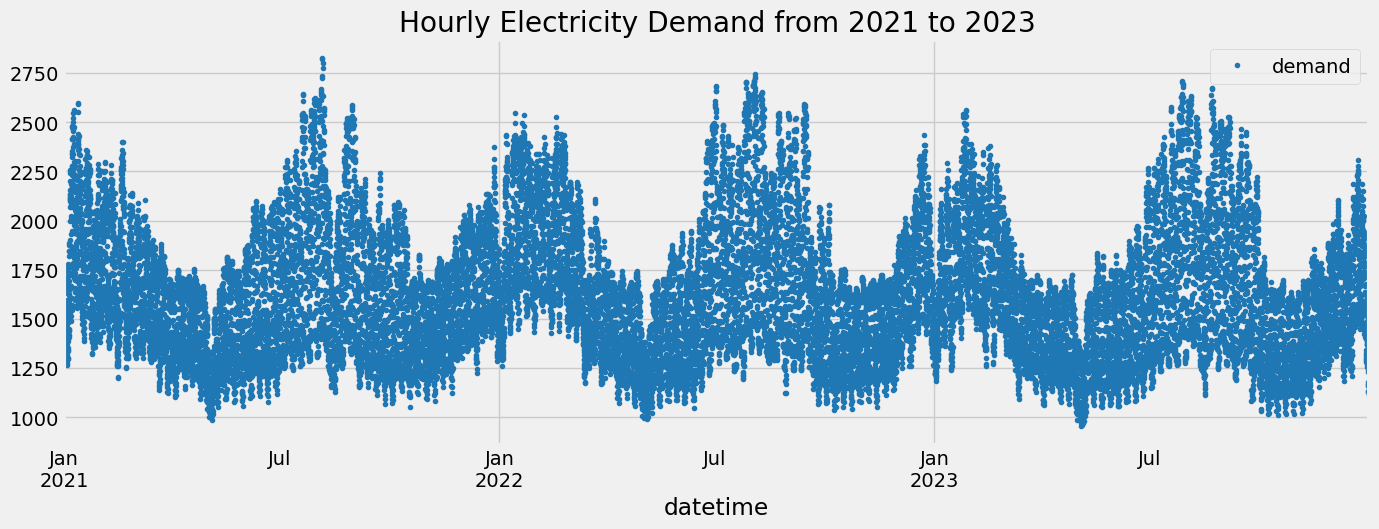

In [8]:
df.plot(style = '.', figsize = (15,5), y= 'demand', color= color_pal[0], title = 'Hourly Electricity Demand from 2021 to 2023')
plt.show()

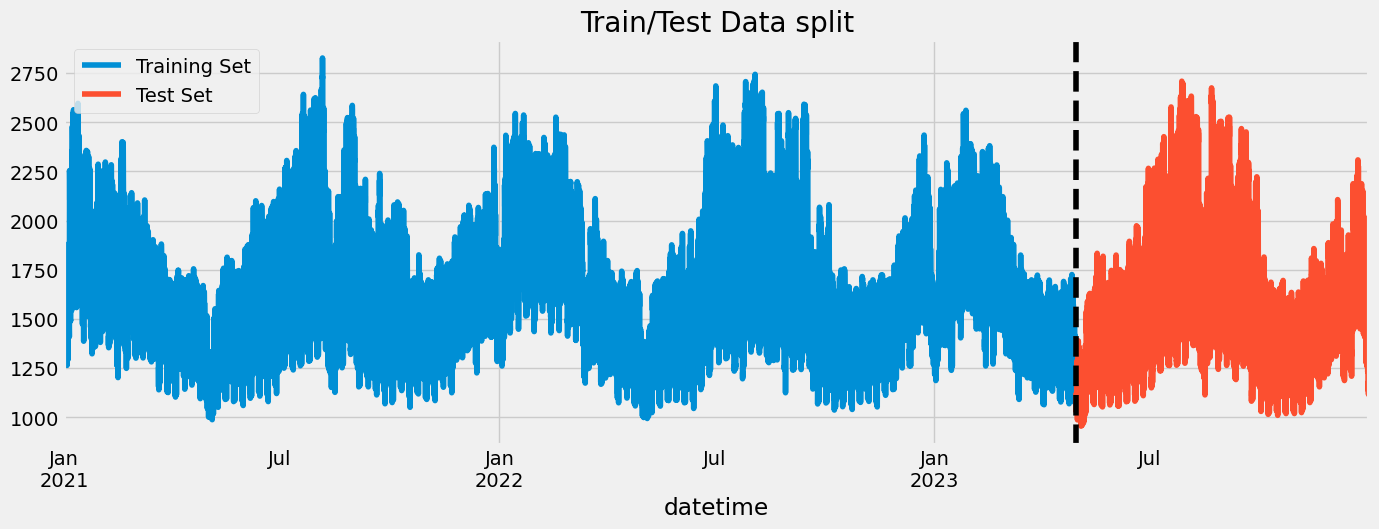

In [9]:
#Train/Test split

train = df.loc[df.index <= '04-30-2023']
test = df.loc[df.index > '04-30-2023']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, y= 'demand', label = 'Training Set', title = 'Train/Test Data split')
test.plot(ax = ax, y= 'demand', label = 'Test Set')
ax.axvline('04-30-2023', color = 'black', ls = '--')
plt.show()

<Axes: title={'center': 'Data of a week'}, xlabel='datetime'>

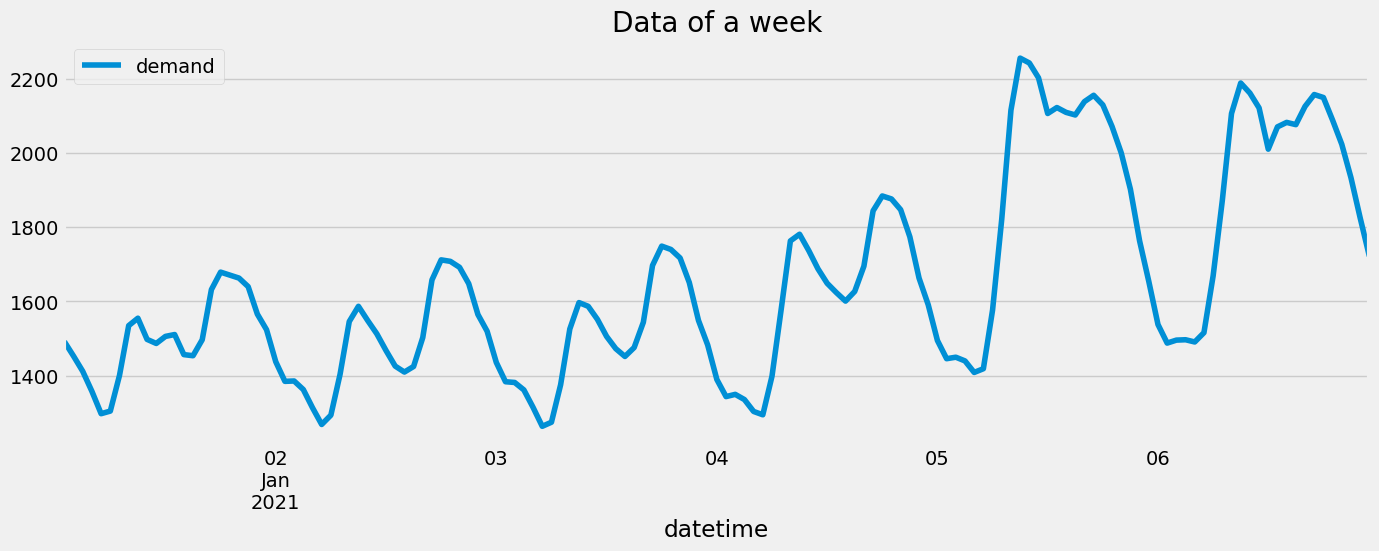

In [10]:
df.loc[(df.index > '01-01-2021') & (df.index < '01-07-2021')].plot(figsize = (15,5),y= 'demand', title = 'Data of a week')

In [11]:
#Feature Creation
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [12]:
# Creating holiday/weekend features
def create_holiday_features(df):

    df = df.copy()
    
    # Basic holiday indicators
    df['is_holiday'] = df.index.map(lambda x: jpholiday.is_holiday(x)).astype(int)
    df['is_weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
    
    return df

df = create_holiday_features(df)

Text(0.5, 1.0, 'Demand by Hour')

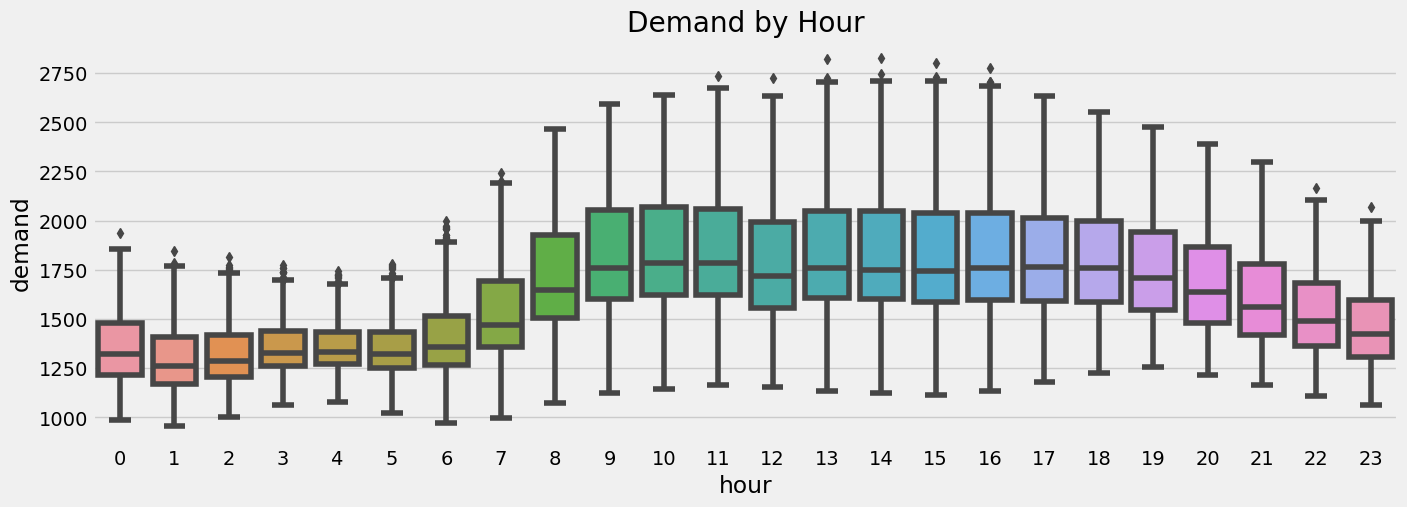

In [13]:
#Visualise the Feature/Target Relationship
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'hour', y='demand')
ax.set_title('Demand by Hour')

Text(0.5, 1.0, 'Demand by month')

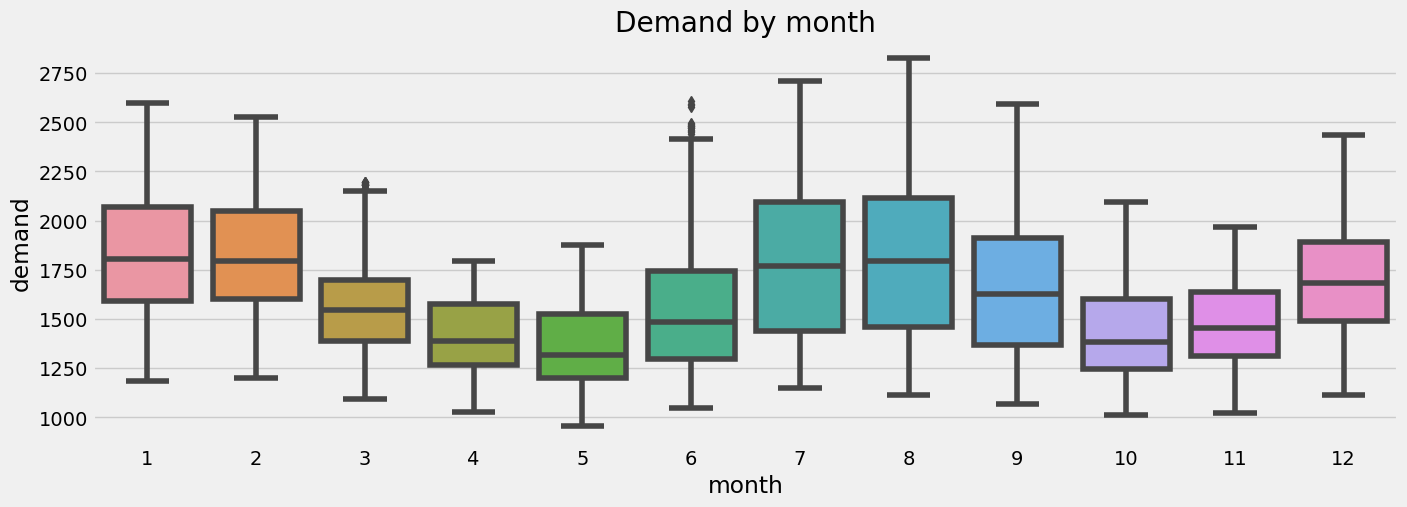

In [14]:
#Visualise the Feature/Target Relationship
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y='demand')
ax.set_title('Demand by month')

In [15]:
df.columns

Index(['demand', 'precipitation', 'temperature', 'dew_point_temperature',
       'humidity', 'wind_speed', 'wind_direction', 'snowfall', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_holiday',
       'is_weekend'],
      dtype='object')

In [16]:
#Creating our Model

train = create_features(train)
test = create_features(test)

train = create_holiday_features(train)
test = create_holiday_features(test)

FEATURES = ['precipitation', 'temperature', 'dew_point_temperature',
       'humidity', 'wind_speed', 'snowfall','hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_holiday', 'is_weekend']
TARGET = 'demand'

In [17]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(learning_rate=0.01,
    n_estimators=2000,
    max_depth=8,  # Increased to capture holiday patterns
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=100)

reg.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 100)

[0]	validation_0-rmse:320.03678	validation_1-rmse:345.99654
[100]	validation_0-rmse:144.85732	validation_1-rmse:159.52480
[200]	validation_0-rmse:76.87199	validation_1-rmse:97.87781
[300]	validation_0-rmse:49.96284	validation_1-rmse:80.01496
[400]	validation_0-rmse:38.47550	validation_1-rmse:73.34222
[500]	validation_0-rmse:32.08830	validation_1-rmse:69.49110
[600]	validation_0-rmse:28.31919	validation_1-rmse:67.18765
[700]	validation_0-rmse:25.74186	validation_1-rmse:65.61863
[800]	validation_0-rmse:23.89555	validation_1-rmse:64.76745
[900]	validation_0-rmse:22.37274	validation_1-rmse:64.13978
[1000]	validation_0-rmse:21.08591	validation_1-rmse:63.62116
[1100]	validation_0-rmse:19.93676	validation_1-rmse:63.32975
[1200]	validation_0-rmse:18.89271	validation_1-rmse:63.13218
[1300]	validation_0-rmse:17.93772	validation_1-rmse:62.94762
[1400]	validation_0-rmse:17.08577	validation_1-rmse:62.88608
[1500]	validation_0-rmse:16.31979	validation_1-rmse:62.77034
[1600]	validation_0-rmse:15.6011

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

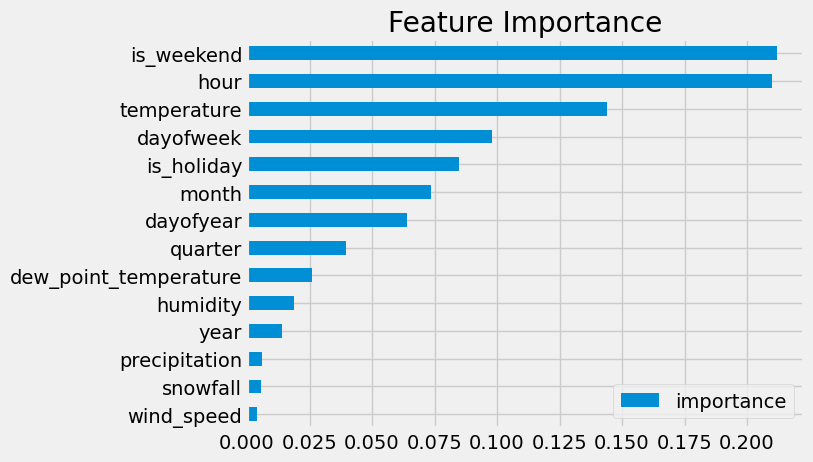

In [19]:
fimp = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['importance'])

fimp.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [20]:
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw Data and Predicted Data')

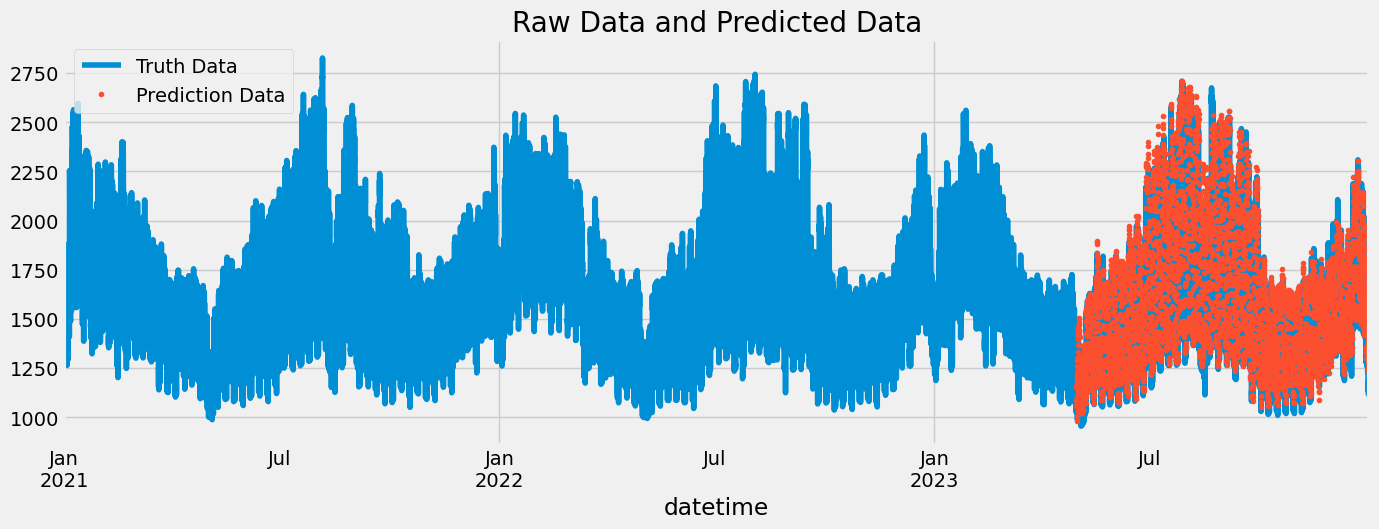

In [21]:
ax = df['demand'].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Raw Data and Predicted Data')

Text(0.5, 1.0, 'Data of a week')

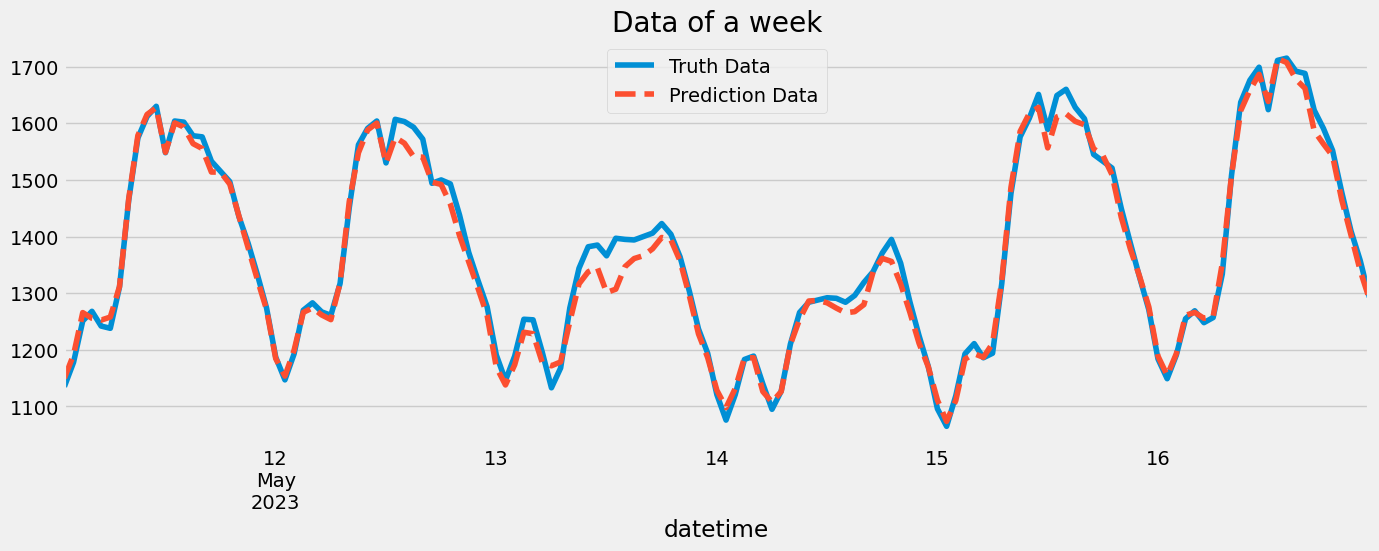

In [22]:
ax = df.loc[(df.index > '05-11-2023') & (df.index < '05-17-2023')]['demand'].plot(figsize = (15,5))
df.loc[(df.index > '05-11-2023') & (df.index < '05-17-2023')]['prediction'].plot(ax = ax, style = '--')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Data of a week')

In [23]:
score = np.sqrt(mean_squared_error(test['demand'], test['prediction']))
print(f'RMSE score on Test set : {score:0.2f}')

RMSE score on Test set : 62.53


In [24]:
test['error'] = np.abs(test[TARGET] -test['prediction'])

test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending = True).head(10)

date
2023-05-11     8.041824
2023-05-09     8.559886
2023-12-06     9.649770
2023-05-16    11.501836
2023-10-01    12.938873
2023-05-19    13.040034
2023-05-14    13.325363
2023-05-10    13.350311
2023-12-08    13.605235
2023-12-04    14.059789
Name: error, dtype: float64

In [25]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

date
2023-08-15    391.047541
2023-08-14    271.286250
2023-08-16    192.768133
2023-08-21    115.458567
2023-08-17    115.133911
Name: error, dtype: float64